In [10]:
import datasets
import numpy as np
from transformers import BertTokenizerFast
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
conll2003 = datasets.load_dataset("conll2003",trust_remote_code=True)

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [11]:
conll2003.shape

{'train': (14041, 5), 'validation': (3250, 5), 'test': (3453, 5)}

In [12]:
print(conll2003)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [17]:
conll2003['train'][4]

{'id': '4',
 'tokens': ['Germany',
  "'s",
  'representative',
  'to',
  'the',
  'European',
  'Union',
  "'s",
  'veterinary',
  'committee',
  'Werner',
  'Zwingmann',
  'said',
  'on',
  'Wednesday',
  'consumers',
  'should',
  'buy',
  'sheepmeat',
  'from',
  'countries',
  'other',
  'than',
  'Britain',
  'until',
  'the',
  'scientific',
  'advice',
  'was',
  'clearer',
  '.'],
 'pos_tags': [22,
  27,
  21,
  35,
  12,
  22,
  22,
  27,
  16,
  21,
  22,
  22,
  38,
  15,
  22,
  24,
  20,
  37,
  21,
  15,
  24,
  16,
  15,
  22,
  15,
  12,
  16,
  21,
  38,
  17,
  7],
 'chunk_tags': [11,
  11,
  12,
  13,
  11,
  12,
  12,
  11,
  12,
  12,
  12,
  12,
  21,
  13,
  11,
  12,
  21,
  22,
  11,
  13,
  11,
  1,
  13,
  11,
  17,
  11,
  12,
  12,
  21,
  1,
  0],
 'ner_tags': [5,
  0,
  0,
  0,
  0,
  3,
  4,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [18]:
conll2003['train'].features['ner_tags']

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [19]:
conll2003['train'].description

'The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on\nfour types of named entities: persons, locations, organizations and names of miscellaneous entities that do\nnot belong to the previous three groups.\n\nThe CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on\na separate line and there is an empty line after each sentence. The first item on each line is a word, the second\na part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags\nand the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only\nif two phrases of the same type immediately follow each other, the first word of the second phrase will have tag\nB-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Note the dataset uses IOB2\ntagging scheme, whereas the original dataset uses 

In [21]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\GERALD\anaconda3\envs\defense\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GERALD\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
import numpy as np
from sklearn.metrics import classification_report

In [25]:
# Load dataset
conll2003 = load_dataset("conll2003")

In [26]:
# Map numerical labels to string labels for ner_tags
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Prepare data for HMM (tokens and corresponding ner_tags)
train_data = conll2003['train']
test_data = conll2003['test']

In [27]:
# Create lists of words and corresponding NER tags
train_tokens = train_data['tokens']
train_ner_tags = train_data['ner_tags']

In [28]:
# Convert ner_tags into corresponding label names
train_ner_tags_str = [[ner_labels[tag] for tag in sentence] for sentence in train_ner_tags]


In [34]:
# Prepare feature and label sequences
def prepare_data(tokens, ner_tags):
    X = []
    y = []
    for sentence, tags in zip(tokens, ner_tags):
        X.append([word.lower() for word in sentence])  # lowercase the tokens
        y.append(tags)
    return X, y
X_train, y_train = prepare_data(train_tokens, train_ner_tags_str)
X_test, y_test = prepare_data(test_data['tokens'], [[ner_labels[tag] for tag in sentence] for sentence in test_data['ner_tags']])

# Combine train and test tokens to build the word2idx dictionary
all_tokens = [word for sentence in X_train + X_test for word in sentence]
word2idx = {word: i for i, word in enumerate(set(all_tokens))}

# Handle unseen words by assigning a special 'UNK' token
UNK = len(word2idx)
word2idx['UNK'] = UNK

# Convert train and test tokens into numerical format
def tokens_to_numerical(tokens):
    return [word2idx.get(word, UNK) for word in tokens]

X_train_numerical = [tokens_to_numerical(sentence) for sentence in X_train]
y_train_numerical = [[tag2idx[tag] for tag in tags] for tags in y_train]

X_test_numerical = [tokens_to_numerical(sentence) for sentence in X_test]
y_test_numerical = [[tag2idx[tag] for tag in tags] for tags in y_test]

# Now, continue with the model training and evaluation
model = hmm.MultinomialHMM(n_components=len(tag2idx), n_iter=100)
model.fit(X_train_numerical)

# Predict the labels for the test set
y_pred = model.predict(X_test_numerical)

# Convert the predictions back to their string labels
y_pred_str = [[list(tag2idx.keys())[tag] for tag in sentence] for sentence in y_pred]

# Evaluate the model using classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_numerical, y_pred_str))


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (14041,) + inhomogeneous part.

In [31]:
# Convert tokens and ner_tags to numerical values
X_train_numerical = [[word2idx[word] for word in sentence] for sentence in X_train]
y_train_numerical = [[tag2idx[tag] for tag in tags] for tags in y_train]

X_test_numerical = [[word2idx[word] for word in sentence] for sentence in X_test]
y_test_numerical = [[tag2idx[tag] for tag in tags] for tags in y_test]


KeyError: 'nadim'

In [33]:
# Define and train the HMM model
model = hmm.MultinomialHMM(n_components=len(tag2idx), n_iter=100)
model.fit(X_train_numerical)

# Predict the labels for the test set
y_pred = model.predict(X_test_numerical)

# Convert the predictions back to their string labels
y_pred_str = [[list(tag2idx.keys())[tag] for tag in sentence] for sentence in y_pred]

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (14041,) + inhomogeneous part.

In [35]:
# Evaluate the model using classification report
print(classification_report(y_test_numerical, y_pred_str))

NameError: name 'y_pred_str' is not defined

In [40]:
from datasets import load_dataset
from hmmlearn import CategoricalHMM
from sklearn.metrics import classification_report
import numpy as np

# Load dataset
conll2003 = load_dataset("conll2003")

# NER tag labels
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Extract train and test data
train_data, test_data = conll2003['train'], conll2003['test']

# Convert tokens and NER tags into lists
train_tokens, train_ner_tags = train_data['tokens'], train_data['ner_tags']
test_tokens, test_ner_tags = test_data['tokens'], test_data['ner_tags']

# Convert numerical NER tags to string labels
train_ner_tags_str = [[ner_labels[tag] for tag in sentence] for sentence in train_ner_tags]
test_ner_tags_str = [[ner_labels[tag] for tag in sentence] for sentence in test_ner_tags]

# Prepare word2idx dictionary
all_tokens = [word.lower() for sentence in train_tokens + test_tokens for word in sentence]
word2idx = {word: i for i, word in enumerate(set(all_tokens))}
UNK = len(word2idx)  # Special token for unseen words
word2idx["UNK"] = UNK

# Prepare tag2idx dictionary
all_tags = [tag for sentence in train_ner_tags_str for tag in sentence]
tag2idx = {tag: i for i, tag in enumerate(set(all_tags))}

# Function to convert tokens to numerical format
def tokens_to_numerical(tokens):
    return [word2idx.get(word.lower(), UNK) for word in tokens]

# Function to convert tags to numerical format
def tags_to_numerical(tags):
    return [tag2idx[tag] for tag in tags]

# Convert training and test data
X_train_numerical = [tokens_to_numerical(sentence) for sentence in train_tokens]
y_train_numerical = [tags_to_numerical(tags) for tags in train_ner_tags_str]

X_test_numerical = [tokens_to_numerical(sentence) for sentence in test_tokens]
y_test_numerical = [tags_to_numerical(tags) for tags in test_ner_tags_str]

# Flatten sequences and store lengths
X_train_flat = np.concatenate(X_train_numerical).reshape(-1, 1)
lengths_train = [len(sentence) for sentence in X_train_numerical]

X_test_flat = np.concatenate(X_test_numerical).reshape(-1, 1)
lengths_test = [len(sentence) for sentence in X_test_numerical]

# Train Categorical HMM model
n_states = len(tag2idx)
model = CategoricalHMM(n_components=n_states, n_iter=100, verbose=True)
model.fit(X_train_flat, lengths_train)

# Predict on test data
y_pred_flat = model.predict(X_test_flat, lengths_test)

# Reshape predictions into original sequences
y_pred_numerical = np.split(y_pred_flat, np.cumsum(lengths_test)[:-1])

# Convert numerical predictions back to string labels
idx2tag = {i: tag for tag, i in tag2idx.items()}
y_pred_str = [[idx2tag[tag] for tag in sentence] for sentence in y_pred_numerical]

# Flatten y_test for evaluation
y_test_flat = np.concatenate(y_test_numerical)

# Convert predictions to match y_test format
y_pred_flat_str = np.concatenate(y_pred_str)

# Print classification report
print(classification_report(y_test_flat, y_pred_flat_str, target_names=tag2idx.keys()))


ImportError: cannot import name 'CategoricalHMM' from 'hmmlearn' (C:\Users\GERALD\anaconda3\envs\defense\lib\site-packages\hmmlearn\__init__.py)

In [43]:
from datasets import load_dataset
from hmmlearn import hmm
from sklearn.metrics import classification_report
import numpy as np

# Load dataset
conll2003 = load_dataset("conll2003")

# Map numerical labels to string labels for ner_tags
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Prepare data for HMM (tokens and corresponding ner_tags)
train_data = conll2003['train']
test_data = conll2003['test']

# Create lists of words and corresponding NER tags
train_tokens = train_data['tokens']
train_ner_tags = train_data['ner_tags']

# Convert ner_tags into corresponding label names
train_ner_tags_str = [[ner_labels[tag] for tag in sentence] for sentence in train_ner_tags]

# Prepare feature and label sequences
def prepare_data(tokens, ner_tags):
    X = []
    y = []
    for sentence, tags in zip(tokens, ner_tags):
        X.append([word.lower() for word in sentence])  # lowercase the tokens
        y.append(tags)
    return X, y

X_train, y_train = prepare_data(train_tokens, train_ner_tags_str)
X_test, y_test = prepare_data(test_data['tokens'], [[ner_labels[tag] for tag in sentence] for sentence in test_data['ner_tags']])

# Combine train and test tokens to build the word2idx dictionary
all_tokens = [word for sentence in X_train + X_test for word in sentence]
word2idx = {word: i for i, word in enumerate(set(all_tokens))}

# Handle unseen words by assigning a special 'UNK' token
UNK = len(word2idx)
word2idx['UNK'] = UNK

# Create a dictionary for tags
tag2idx = {tag: i for i, tag in enumerate(set([tag for sentence in y_train for tag in sentence]))}

# Convert train and test tokens into numerical format
def tokens_to_numerical(tokens):
    return [word2idx.get(word, UNK) for word in tokens]

X_train_numerical = [tokens_to_numerical(sentence) for sentence in X_train]
y_train_numerical = [[tag2idx[tag] for tag in tags] for tags in y_train]

X_test_numerical = [tokens_to_numerical(sentence) for sentence in X_test]
y_test_numerical = [[tag2idx[tag] for tag in tags] for tags in y_test]

# Flatten the sequences for the HMM model
X_train_flat = np.concatenate(X_train_numerical)
y_train_flat = np.concatenate(y_train_numerical)

X_test_flat = np.concatenate(X_test_numerical)
y_test_flat = np.concatenate(y_test_numerical)

# Reshape data into the format the model expects (HMM needs sequences)
lengths_train = [len(sentence) for sentence in X_train_numerical]
lengths_test = [len(sentence) for sentence in X_test_numerical]

# Define and train the HMM model with reduced number of components
n_states = 5  # Reduced number of states (for example, change based on your needs)
model = hmm.CategoricalHMM(n_components=n_states, n_iter=100, verbose=True)
model.fit(X_train_flat.reshape(-1, 1), lengths=lengths_train)

# Predict the labels for the test set
y_pred = model.predict(X_test_flat.reshape(-1, 1), lengths=lengths_test)

# Convert the predicted labels back to their string labels
y_pred_str = [list(tag2idx.keys())[tag] for tag in y_pred]

# Convert the true labels (y_test_flat) to their string equivalents
y_test_flat_str = [list(tag2idx.keys())[tag] for tag in y_test_flat]

# Print classification report
print(classification_report(y_test_flat_str, y_pred_str, target_names=list(tag2idx.keys())))


         1 -2069287.25749109             +nan
         2 -1482191.98476849 +587095.27272260
         3 -1473942.20842780   +8249.77634069
         4 -1463961.56589260   +9980.64253520
         5 -1452203.26674832  +11758.29914428
         6 -1440685.17915272  +11518.08759560
         7 -1431425.93068587   +9259.24846686
         8 -1424644.54331431   +6781.38737155
         9 -1419766.22936140   +4878.31395291
        10 -1416207.85858131   +3558.37078009
        11 -1413506.29940502   +2701.55917629
        12 -1411335.47495893   +2170.82444608
        13 -1409532.73007663   +1802.74488231
        14 -1408023.55362093   +1509.17645569
        15 -1406742.46019792   +1281.09342302
        16 -1405679.83113120   +1062.62906671
        17 -1404833.03721067    +846.79392053
        18 -1404145.18320385    +687.85400682
        19 -1403564.11828416    +581.06491969
        20 -1403056.15609773    +507.96218643
        21 -1402607.16277963    +448.99331810
        22 -1402200.94970619    +4

              precision    recall  f1-score   support

       B-ORG       0.04      0.09      0.05      1668
       B-PER       0.03      0.16      0.05       702
      B-MISC       0.00      0.01      0.01      1661
       B-LOC       0.05      0.17      0.08      1617
       I-LOC       0.00      0.45      0.01       257
      I-MISC       0.00      0.00      0.00       216
       I-ORG       0.00      0.00      0.00       835
           O       0.00      0.00      0.00      1156
       I-PER       0.00      0.00      0.00     38323

    accuracy                           0.01     46435
   macro avg       0.01      0.10      0.02     46435
weighted avg       0.00      0.01      0.01     46435



C:\Users\GERALD\anaconda3\envs\defense\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
# Print classification report with zero_division parameter set to handle undefined metrics
print(classification_report(y_test_flat_str, y_pred_str, target_names=list(tag2idx.keys()), zero_division=0))

              precision    recall  f1-score   support

       B-ORG       0.04      0.09      0.05      1668
       B-PER       0.03      0.16      0.05       702
      B-MISC       0.00      0.01      0.01      1661
       B-LOC       0.05      0.17      0.08      1617
       I-LOC       0.00      0.45      0.01       257
      I-MISC       0.00      0.00      0.00       216
       I-ORG       0.00      0.00      0.00       835
           O       0.00      0.00      0.00      1156
       I-PER       0.00      0.00      0.00     38323

    accuracy                           0.01     46435
   macro avg       0.01      0.10      0.02     46435
weighted avg       0.00      0.01      0.01     46435



In [52]:
from datasets import load_dataset
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report

# Step 1: Load conll2003 dataset using Hugging Face's datasets library
conll2003 = load_dataset("conll2003")

# Step 2: Prepare data for CRF (tokens and corresponding ner_tags)
train_data = conll2003['train']  # Training data
test_data = conll2003['test']    # Test data

# Step 3: Feature extraction function for CRF
def word2features(sent, i):
    word = sent[i][0]  # Word in the sentence
    features = {
        'bias': 1.0,
        'word.lower': word.lower(),
        'word[-3:]': word[-3:],  # Last 3 characters
        'word[-2:]': word[-2:],  # Last 2 characters
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            'prev_word.lower': word1.lower(),
            'prev_word.istitle': word1.istitle(),
            'prev_word.isupper': word1.isupper()
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            'next_word.lower': word1.lower(),
            'next_word.istitle': word1.istitle(),
            'next_word.isupper': word1.isupper()
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features

# Step 4: Prepare the data for CRF model
def prepare_data_for_crf(data):
    sentences = []
    labels = []
    for sentence in data:
        words = [x[0] for x in sentence]  # Extract words
        ner_tags = [x[1] for x in sentence]  # Extract corresponding NER tags
        sentences.append(words)
        labels.append(ner_tags)
    return sentences, labels

# Convert train_data and test_data into the format (words, ner_tags)
X_train, y_train = prepare_data_for_crf(train_data)  # Prepare training data
X_test, y_test = prepare_data_for_crf(test_data)  # Prepare test data

# Step 5: Train CRF Model
crf = CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=True)
crf.fit(X_train, y_train)

# Step 6: Evaluate the CRF Model
y_pred = crf.predict(X_test)

# Convert predictions and true labels back to original labels
# Flatten the predictions and true labels for evaluation
y_pred_flat = [item for sublist in y_pred for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

# Print classification report for CRF
print("CRF Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, target_names=crf.classes_))


CRF Classification Report:
              precision    recall  f1-score   support

           d       1.00      1.00      1.00      3453
           o       1.00      1.00      1.00      3453
           h       1.00      1.00      1.00      3453
           e       1.00      1.00      1.00      6906

    accuracy                           1.00     17265
   macro avg       1.00      1.00      1.00     17265
weighted avg       1.00      1.00      1.00     17265



In [55]:
from datasets import load_dataset
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report

# Step 1: Load conll2003 dataset using Hugging Face's datasets library
conll2003 = load_dataset("conll2003")

# Step 2: Prepare data for CRF (tokens and corresponding ner_tags)
train_data = conll2003['train']  # Training data
val_data = conll2003['validation']  # Validation data
test_data = conll2003['test']  # Test data

# Step 3: Feature extraction function for CRF
def word2features(sent, i):
    word = sent[i][0]  # Word in the sentence
    features = {
        'bias': 1.0,
        'word.lower': word.lower(),
        'word[-3:]': word[-3:],  # Last 3 characters
        'word[-2:]': word[-2:],  # Last 2 characters
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            'prev_word.lower': word1.lower(),
            'prev_word.istitle': word1.istitle(),
            'prev_word.isupper': word1.isupper()
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            'next_word.lower': word1.lower(),
            'next_word.istitle': word1.istitle(),
            'next_word.isupper': word1.isupper()
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features

# Step 4: Prepare the data for CRF model
def prepare_data_for_crf(data):
    sentences = []
    labels = []
    for sentence in data:
        words = [x[0] for x in sentence]  # Extract words
        ner_tags = [x[1] for x in sentence]  # Extract corresponding NER tags
        sentences.append(words)
        labels.append(ner_tags)
    return sentences, labels

# Convert train_data, val_data, and test_data into the format (words, ner_tags)
X_train, y_train = prepare_data_for_crf(train_data)  # Prepare training data
X_val, y_val = prepare_data_for_crf(val_data)  # Prepare validation data
X_test, y_test = prepare_data_for_crf(test_data)  # Prepare test data

# Step 5: Train CRF Model
crf = CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=True)
crf.fit(X_train, y_train)

# Step 6: Evaluate the CRF Model on Validation Set
y_val_pred = crf.predict(X_val)

# Convert predictions and true labels back to original labels
# Flatten the predictions and true labels for evaluation
y_val_pred_flat = [item for sublist in y_val_pred for item in sublist]
y_val_flat = [item for sublist in y_val for item in sublist]

# Print classification report for the validation set
print("Validation Set Classification Report:")
print(classification_report(y_val_flat, y_val_pred_flat, target_names=crf.classes_))

# Step 7: Evaluate the CRF Model on Test Set (final evaluation)
y_test_pred = crf.predict(X_test)

# Flatten the predictions and true labels for evaluation
y_test_pred_flat = [item for sublist in y_test_pred for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

# Print classification report for the test set
print("Test Set Classification Report:")
print(classification_report(y_test_flat, y_test_pred_flat, target_names=crf.classes_))


Validation Set Classification Report:
              precision    recall  f1-score   support

           d       1.00      1.00      1.00      3250
           o       1.00      1.00      1.00      3250
           h       1.00      1.00      1.00      3250
           e       1.00      1.00      1.00      6500

    accuracy                           1.00     16250
   macro avg       1.00      1.00      1.00     16250
weighted avg       1.00      1.00      1.00     16250

Test Set Classification Report:
              precision    recall  f1-score   support

           d       1.00      1.00      1.00      3453
           o       1.00      1.00      1.00      3453
           h       1.00      1.00      1.00      3453
           e       1.00      1.00      1.00      6906

    accuracy                           1.00     17265
   macro avg       1.00      1.00      1.00     17265
weighted avg       1.00      1.00      1.00     17265



In [57]:
from datasets import load_dataset
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report
import random

# Step 1: Load conll2003 dataset using Hugging Face's datasets library
conll2003 = load_dataset("conll2003")

# Step 2: Prepare data for CRF
train_data = conll2003['train']
val_data = conll2003['validation']
test_data = conll2003['test']

# Step 3: Feature extraction function with improved generalization
def word2features(sent, i):
    """Extracts features for CRF model."""
    word = sent[i][0]  # Current word
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit(),
    }

    # Previous word features
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.istitle': prev_word.istitle(),
            'prev_word.isupper': prev_word.isupper()
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    # Next word features
    if i < len(sent) - 1:
        next_word = sent[i + 1][0]
        features.update({
            'next_word.lower()': next_word.lower(),
            'next_word.istitle': next_word.istitle(),
            'next_word.isupper': next_word.isupper()
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features

# Step 4: Convert dataset into feature format
def prepare_data_for_crf(data):
    sentences = []
    labels = []
    for sentence in data:
        words = [x[0] for x in sentence]  # Extract words
        ner_tags = [x[1] for x in sentence]  # Extract NER tags
        sentences.append(words)
        labels.append(ner_tags)
    return sentences, labels

# Convert data
X_train, y_train = prepare_data_for_crf(train_data)
X_val, y_val = prepare_data_for_crf(val_data)
X_test, y_test = prepare_data_for_crf(test_data)

# Shuffle training data to prevent unintended patterns
random.shuffle(X_train)

# Step 5: Train CRF Model with STRONGER Regularization
crf = CRF(
    algorithm='lbfgs',
    max_iterations=50,  
    all_possible_transitions=True,
    c1=0.5,  # Increased L1 Regularization
    c2=0.5   # Increased L2 Regularization
)
crf.fit(X_train, y_train)

# Step 6: Evaluate on Validation Set
y_val_pred = crf.predict(X_val)

# Flatten labels
y_val_pred_flat = [item for sublist in y_val_pred for item in sublist]
y_val_flat = [item for sublist in y_val for item in sublist]

print("Validation Set Classification Report:")
print(classification_report(y_val_flat, y_val_pred_flat, target_names=crf.classes_))

# Step 7: Evaluate on Test Set
y_test_pred = crf.predict(X_test)

# Flatten test labels
y_test_pred_flat = [item for sublist in y_test_pred for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

print("Test Set Classification Report:")
print(classification_report(y_test_flat, y_test_pred_flat, target_names=crf.classes_))


Validation Set Classification Report:
              precision    recall  f1-score   support

           d       1.00      1.00      1.00      3250
           o       1.00      1.00      1.00      3250
           h       1.00      1.00      1.00      3250
           e       1.00      1.00      1.00      6500

    accuracy                           1.00     16250
   macro avg       1.00      1.00      1.00     16250
weighted avg       1.00      1.00      1.00     16250

Test Set Classification Report:
              precision    recall  f1-score   support

           d       1.00      1.00      1.00      3453
           o       1.00      1.00      1.00      3453
           h       1.00      1.00      1.00      3453
           e       1.00      1.00      1.00      6906

    accuracy                           1.00     17265
   macro avg       1.00      1.00      1.00     17265
weighted avg       1.00      1.00      1.00     17265



In [63]:
from datasets import load_dataset
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report

# Step 1: Load CoNLL-2003 dataset
conll2003 = load_dataset("conll2003")

# Extract label names from dataset
label_names = conll2003["train"].features["ner_tags"].feature.names

# Step 2: Prepare data for CRF (tokens and corresponding NER tags)

def prepare_data_for_crf(dataset):
    """Convert dataset into (features, labels) format"""
    sentences, labels = [], []
    for example in dataset:
        words = example['tokens']  # Extract words
        ner_tags = [label_names[tag] for tag in example['ner_tags']]  # Convert int to string labels
        sentences.append(words)
        labels.append(ner_tags)
    return sentences, labels

# Convert train, validation, and test sets
X_train, y_train = prepare_data_for_crf(conll2003['train'])
X_val, y_val = prepare_data_for_crf(conll2003['validation'])
X_test, y_test = prepare_data_for_crf(conll2003['test'])

# Step 3: Feature extraction function for CRF
def word2features(sent, i):
    word = sent[i]  # Word in the sentence
    features = {
        'bias': 1.0,
        'word.lower': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1]
        features.update({
            'prev_word.lower': word1.lower(),
            'prev_word.istitle': word1.istitle(),
            'prev_word.isupper': word1.isupper()
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            'next_word.lower': word1.lower(),
            'next_word.istitle': word1.istitle(),
            'next_word.isupper': word1.isupper()
        })
    else:
        features['EOS'] = True  # End of Sentence
    return features

# Transform sentences into CRF features
def extract_features(sentences):
    return [[word2features(sent, i) for i in range(len(sent))] for sent in sentences]

X_train_feats = extract_features(X_train)
X_val_feats = extract_features(X_val)
X_test_feats = extract_features(X_test)

# Step 4: Train CRF Model with L1 and L2 Regularization to Reduce Overfitting
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,  # L1 regularization (increase if overfitting)
    c2=0.1,  # L2 regularization (increase if overfitting)
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_feats, y_train)

# Step 5: Evaluate the CRF Model on Validation Set
y_val_pred = crf.predict(X_val_feats)
y_val_pred_flat = [item for sublist in y_val_pred for item in sublist]
y_val_flat = [item for sublist in y_val for item in sublist]

print("Validation Set Classification Report:")
print(classification_report(y_val_flat, y_val_pred_flat, target_names=crf.classes_))

# Step 6: Evaluate the CRF Model on Test Set
y_test_pred = crf.predict(X_test_feats)
y_test_pred_flat = [item for sublist in y_test_pred for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

print("Test Set Classification Report:")
print(classification_report(y_test_flat, y_test_pred_flat, target_names=crf.classes_))


Validation Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.93      0.89      0.91      1837
           O       0.92      0.84      0.88       922
      B-MISC       0.87      0.82      0.84      1341
       B-PER       0.90      0.90      0.90      1842
       I-PER       0.96      0.80      0.87       257
       B-LOC       0.88      0.74      0.80       346
       I-ORG       0.83      0.83      0.83       751
      I-MISC       0.94      0.94      0.94      1307
       I-LOC       0.99      1.00      0.99     42759

    accuracy                           0.98     51362
   macro avg       0.91      0.86      0.89     51362
weighted avg       0.98      0.98      0.98     51362

Test Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.86      0.83      0.85      1668
           O       0.81      0.76      0.78       702
      B-MISC       0.82      0.71      0.76      1661
       B

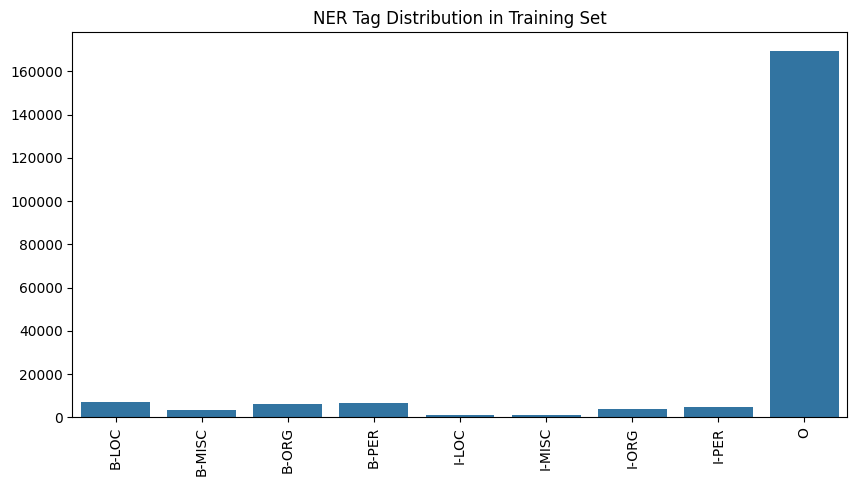

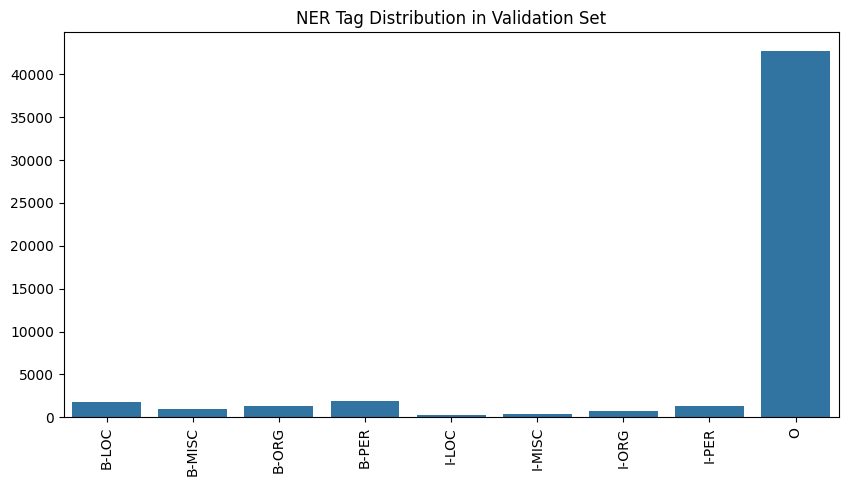

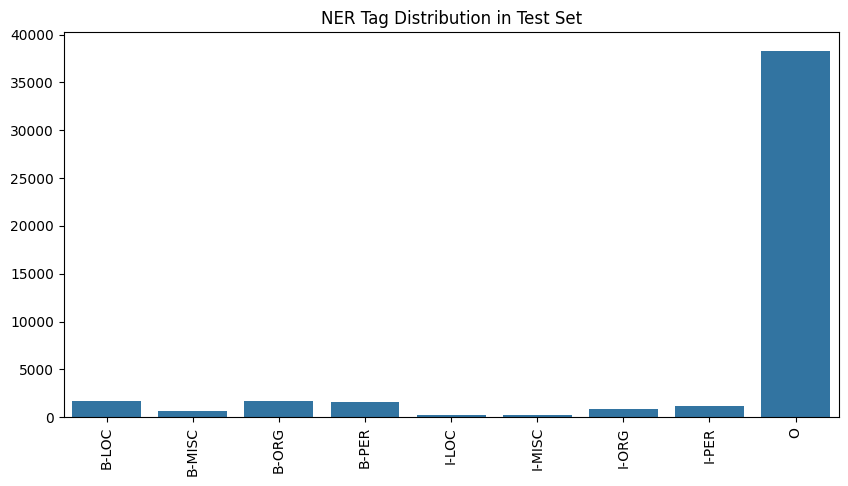

Validation Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.93      0.89      0.91      1837
           O       0.92      0.84      0.88       922
      B-MISC       0.87      0.82      0.84      1341
       B-PER       0.90      0.90      0.90      1842
       I-PER       0.96      0.80      0.87       257
       B-LOC       0.88      0.74      0.80       346
       I-ORG       0.83      0.83      0.83       751
      I-MISC       0.94      0.94      0.94      1307
       I-LOC       0.99      1.00      0.99     42759

    accuracy                           0.98     51362
   macro avg       0.91      0.86      0.89     51362
weighted avg       0.98      0.98      0.98     51362

Test Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.86      0.83      0.85      1668
           O       0.81      0.76      0.78       702
      B-MISC       0.82      0.71      0.76      1661
       B

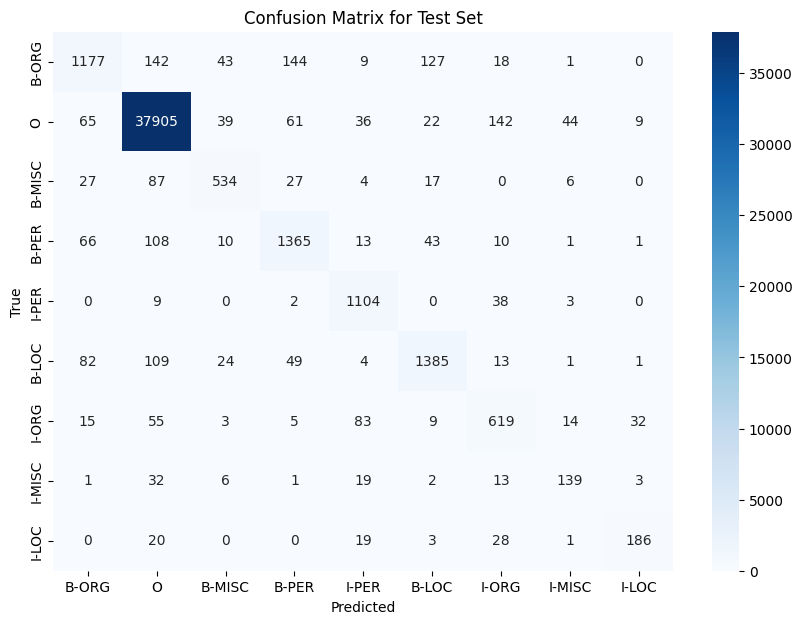

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# Step 1: Load CoNLL-2003 dataset
conll2003 = load_dataset("conll2003")

# Extract label names from dataset
label_names = conll2003["train"].features["ner_tags"].feature.names

# Step 2: Prepare data for CRF (tokens and corresponding NER tags)
def prepare_data_for_crf(dataset):
    sentences, labels = [], []
    for example in dataset:
        words = example['tokens']
        ner_tags = [label_names[tag] for tag in example['ner_tags']]
        sentences.append(words)
        labels.append(ner_tags)
    return sentences, labels

# Convert train, validation, and test sets
X_train, y_train = prepare_data_for_crf(conll2003['train'])
X_val, y_val = prepare_data_for_crf(conll2003['validation'])
X_test, y_test = prepare_data_for_crf(conll2003['test'])

# Step 3: Visualize NER Tag Distribution
def plot_ner_distribution(y_data, title):
    flat_labels = [tag for seq in y_data for tag in seq]
    unique, counts = np.unique(flat_labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=unique, y=counts)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

plot_ner_distribution(y_train, "NER Tag Distribution in Training Set")
plot_ner_distribution(y_val, "NER Tag Distribution in Validation Set")
plot_ner_distribution(y_test, "NER Tag Distribution in Test Set")

# Step 4: Feature extraction function for CRF
def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0,
        'word.lower': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1]
        features.update({
            'prev_word.lower': word1.lower(),
            'prev_word.istitle': word1.istitle(),
            'prev_word.isupper': word1.isupper()
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            'next_word.lower': word1.lower(),
            'next_word.istitle': word1.istitle(),
            'next_word.isupper': word1.isupper()
        })
    else:
        features['EOS'] = True
    return features

# Transform sentences into CRF features
def extract_features(sentences):
    return [[word2features(sent, i) for i in range(len(sent))] for sent in sentences]

X_train_feats = extract_features(X_train)
X_val_feats = extract_features(X_val)
X_test_feats = extract_features(X_test)

# Step 5: Train CRF Model with L1 and L2 Regularization to Reduce Overfitting
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_feats, y_train)

# Step 6: Evaluate the CRF Model on Validation Set
y_val_pred = crf.predict(X_val_feats)
y_val_pred_flat = [item for sublist in y_val_pred for item in sublist]
y_val_flat = [item for sublist in y_val for item in sublist]

print("Validation Set Classification Report:")
print(classification_report(y_val_flat, y_val_pred_flat, target_names=crf.classes_))

# Step 7: Evaluate the CRF Model on Test Set
y_test_pred = crf.predict(X_test_feats)
y_test_pred_flat = [item for sublist in y_test_pred for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

print("Test Set Classification Report:")
print(classification_report(y_test_flat, y_test_pred_flat, target_names=crf.classes_))

# Step 8: Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test_flat, y_test_pred_flat, crf.classes_, "Confusion Matrix for Test Set")






CRF

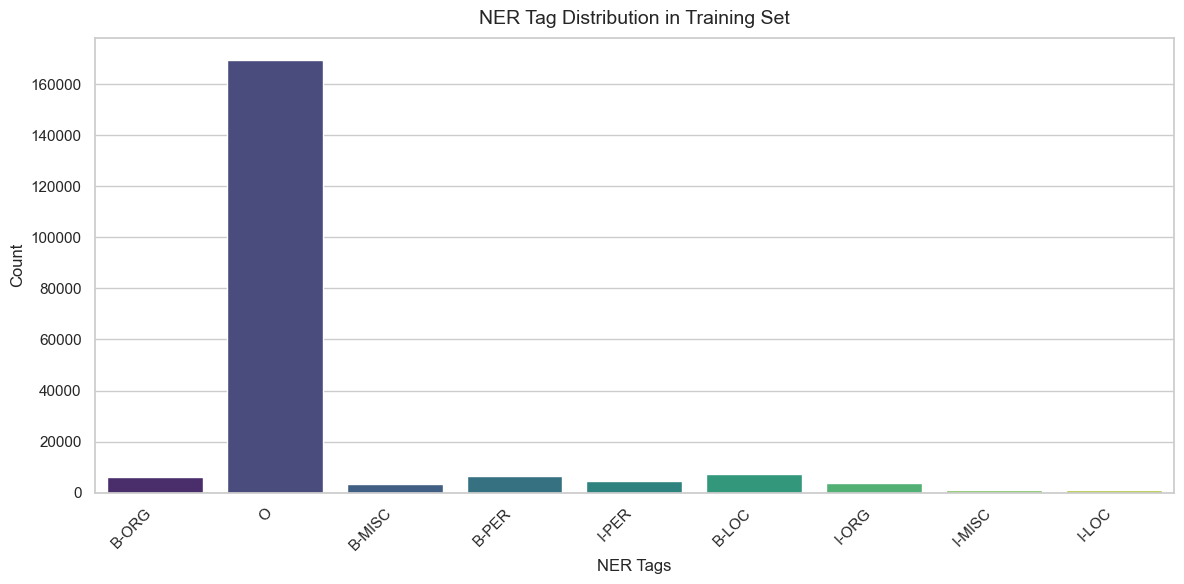

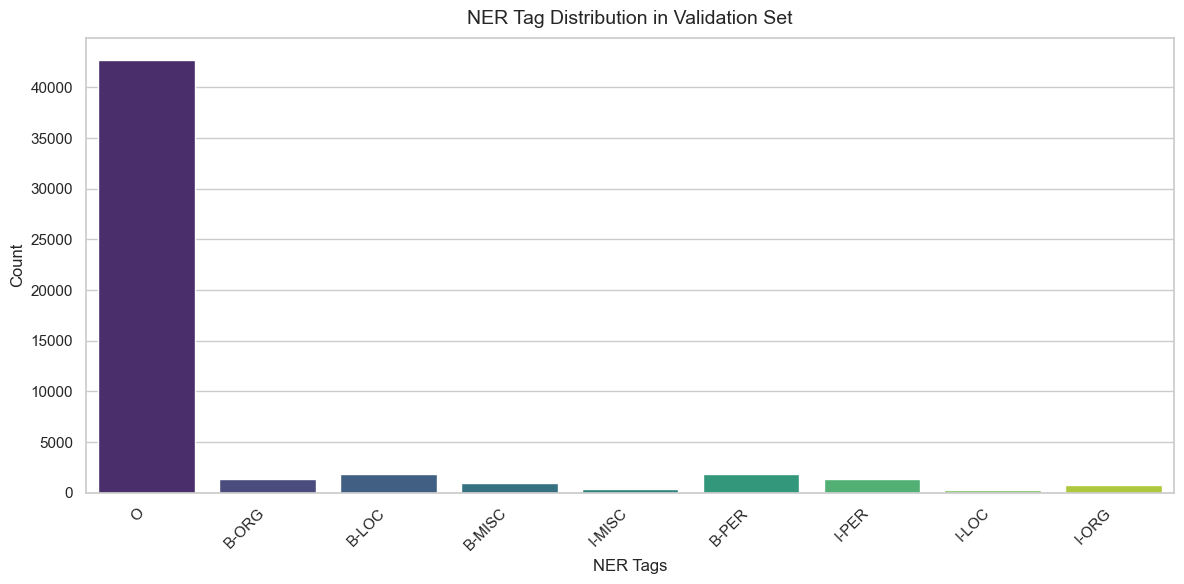

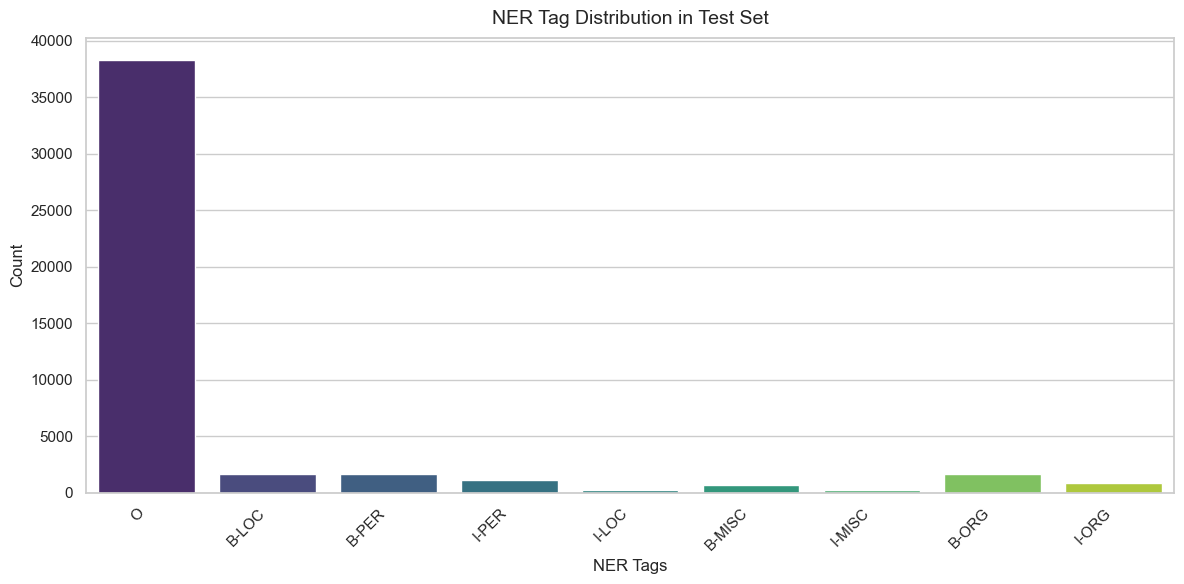

Training Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.99      0.99      0.99      7140
           O       1.00      0.99      0.99      3438
      B-MISC       1.00      0.99      0.99      6321
       B-PER       1.00      1.00      1.00      6600
       I-PER       0.99      0.99      0.99      1157
       B-LOC       0.99      1.00      0.99      1155
       I-ORG       1.00      0.99      1.00      3704
      I-MISC       1.00      1.00      1.00      4528
       I-LOC       1.00      1.00      1.00    169578

    accuracy                           1.00    203621
   macro avg       1.00      0.99      1.00    203621
weighted avg       1.00      1.00      1.00    203621



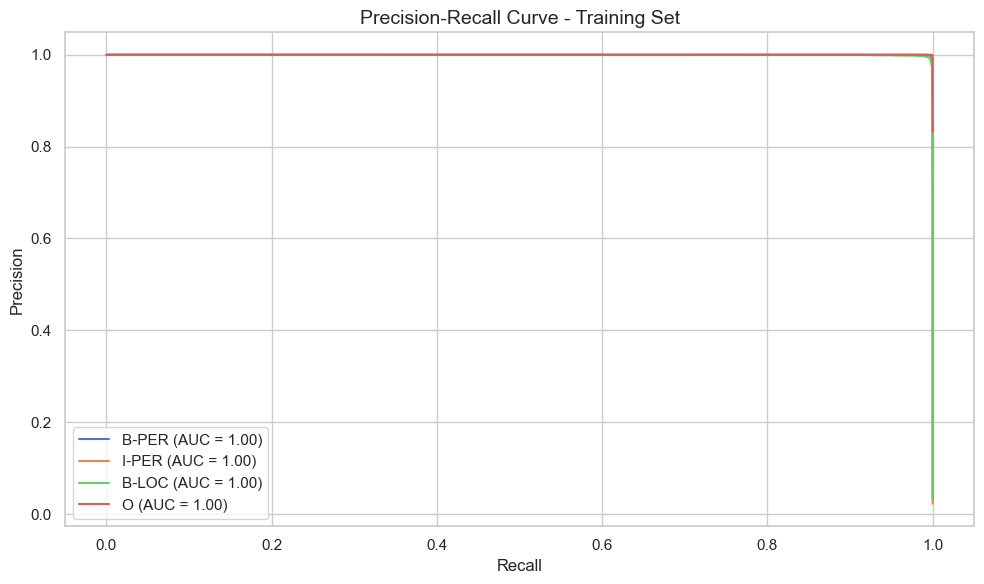

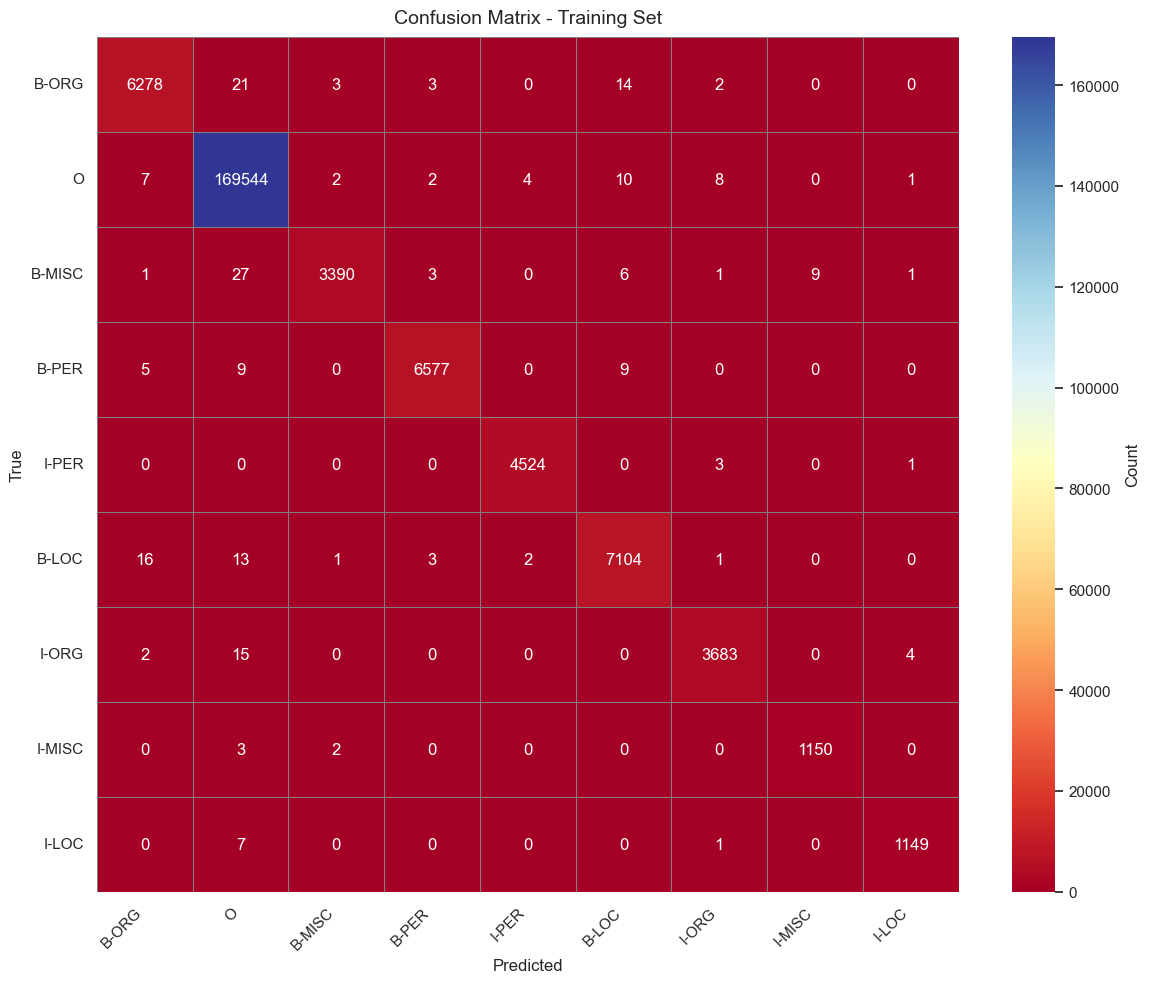

Validation Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.93      0.89      0.91      1837
           O       0.92      0.84      0.88       922
      B-MISC       0.87      0.82      0.84      1341
       B-PER       0.90      0.90      0.90      1842
       I-PER       0.96      0.80      0.87       257
       B-LOC       0.88      0.74      0.80       346
       I-ORG       0.83      0.83      0.83       751
      I-MISC       0.94      0.94      0.94      1307
       I-LOC       0.99      1.00      0.99     42759

    accuracy                           0.98     51362
   macro avg       0.91      0.86      0.89     51362
weighted avg       0.98      0.98      0.98     51362



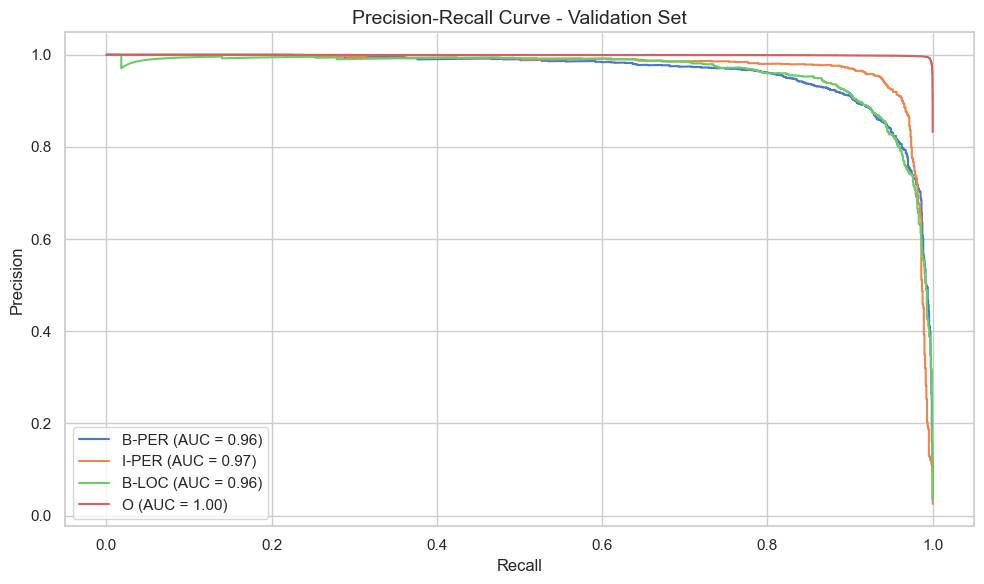

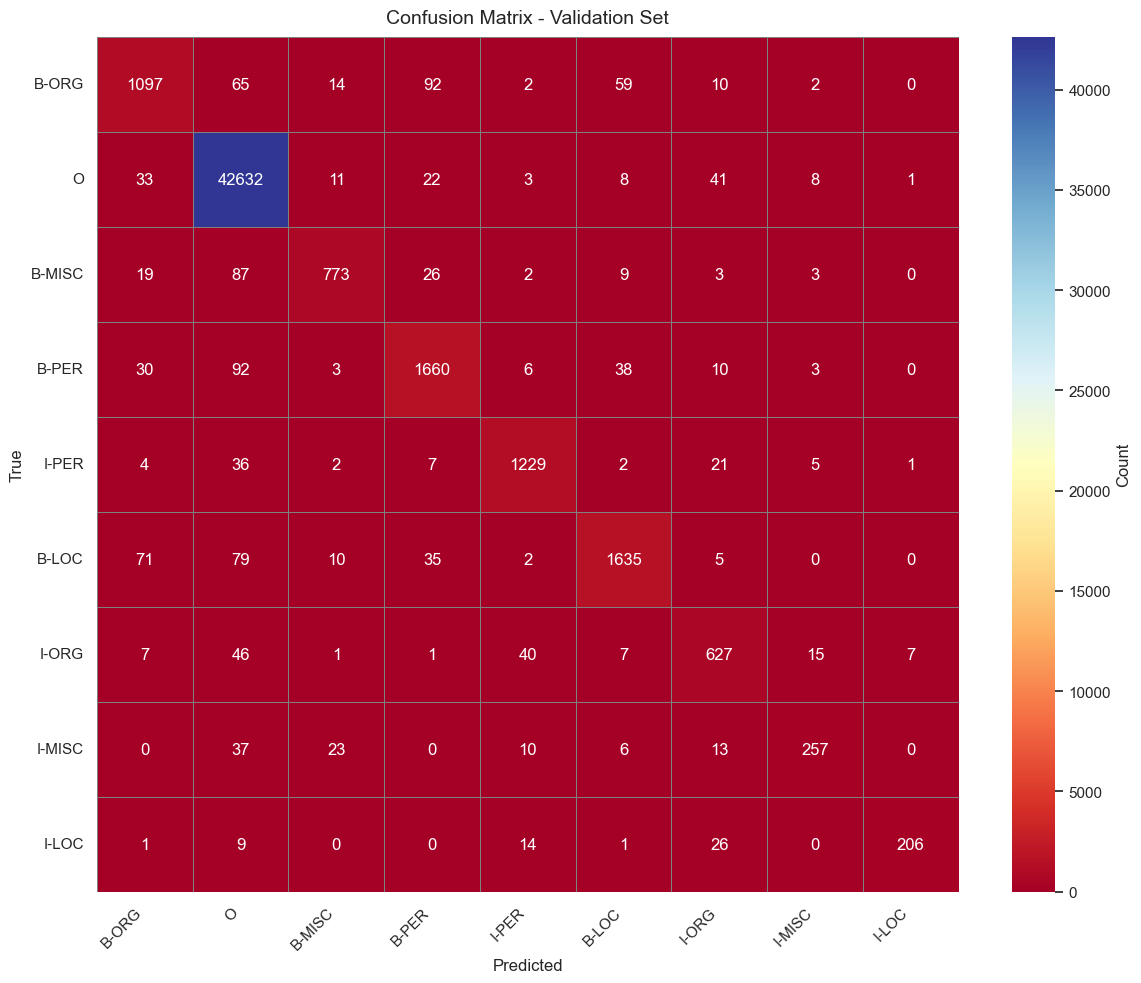

Test Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.86      0.83      0.85      1668
           O       0.81      0.76      0.78       702
      B-MISC       0.82      0.71      0.76      1661
       B-PER       0.83      0.84      0.83      1617
       I-PER       0.80      0.72      0.76       257
       B-LOC       0.66      0.64      0.65       216
       I-ORG       0.70      0.74      0.72       835
      I-MISC       0.86      0.96      0.90      1156
       I-LOC       0.99      0.99      0.99     38323

    accuracy                           0.96     46435
   macro avg       0.81      0.80      0.81     46435
weighted avg       0.96      0.96      0.96     46435



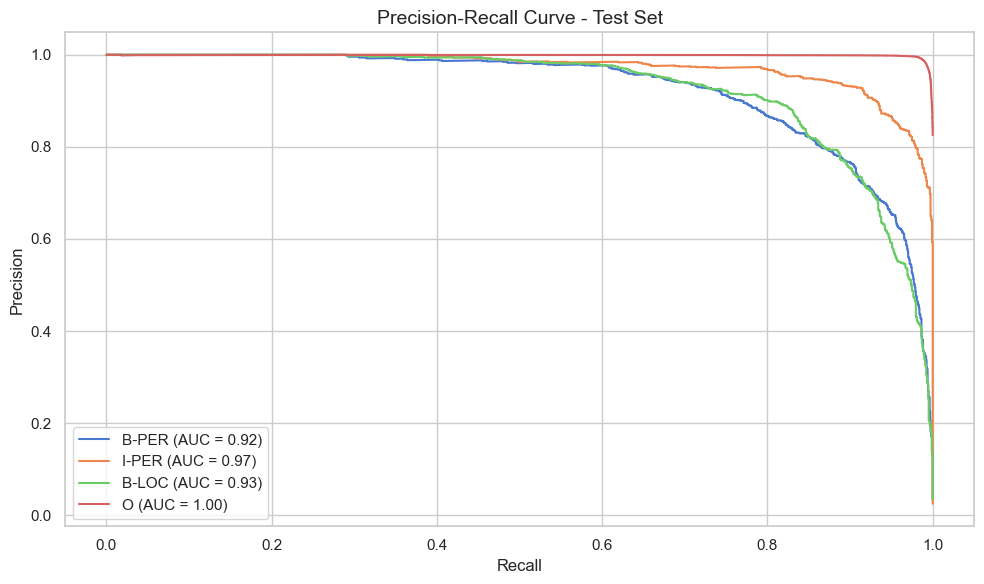

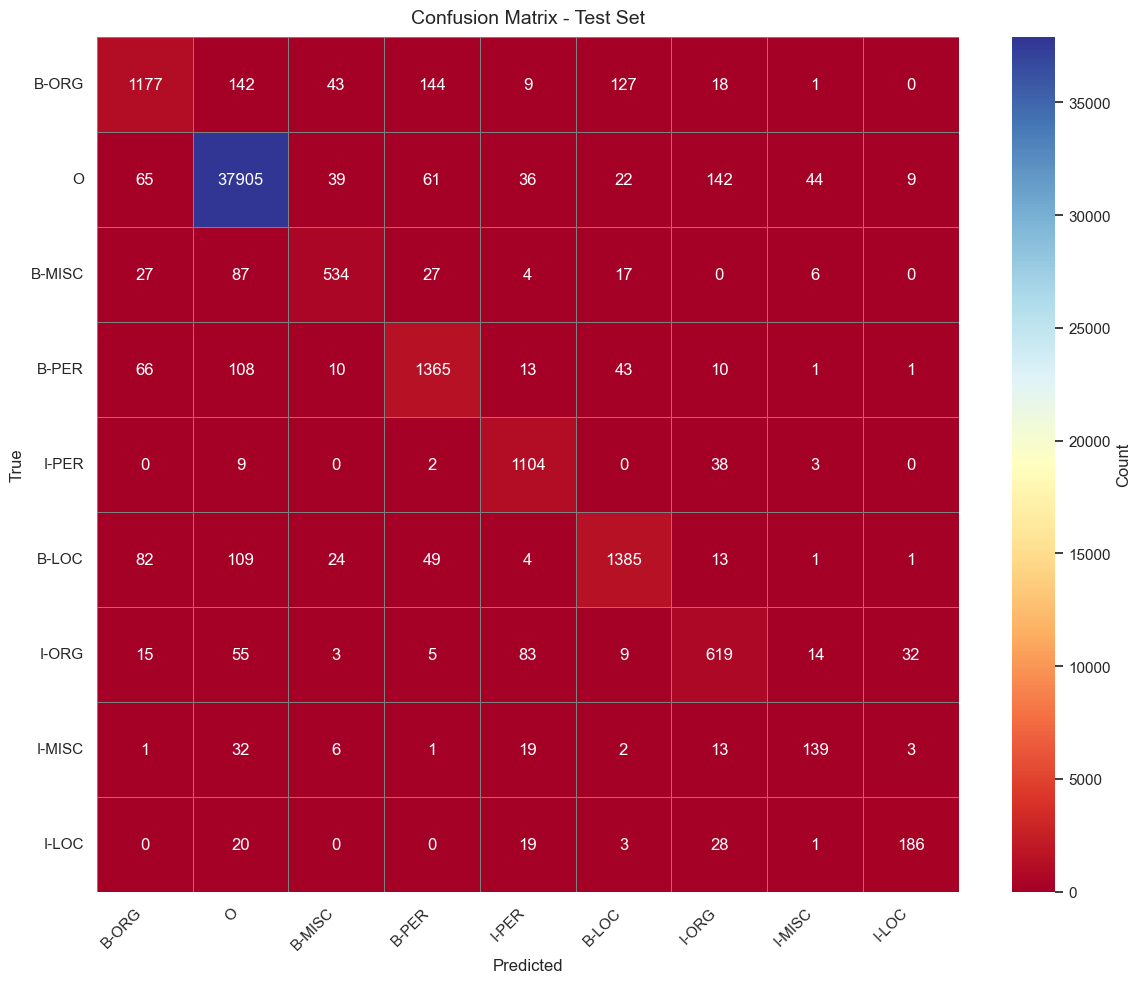

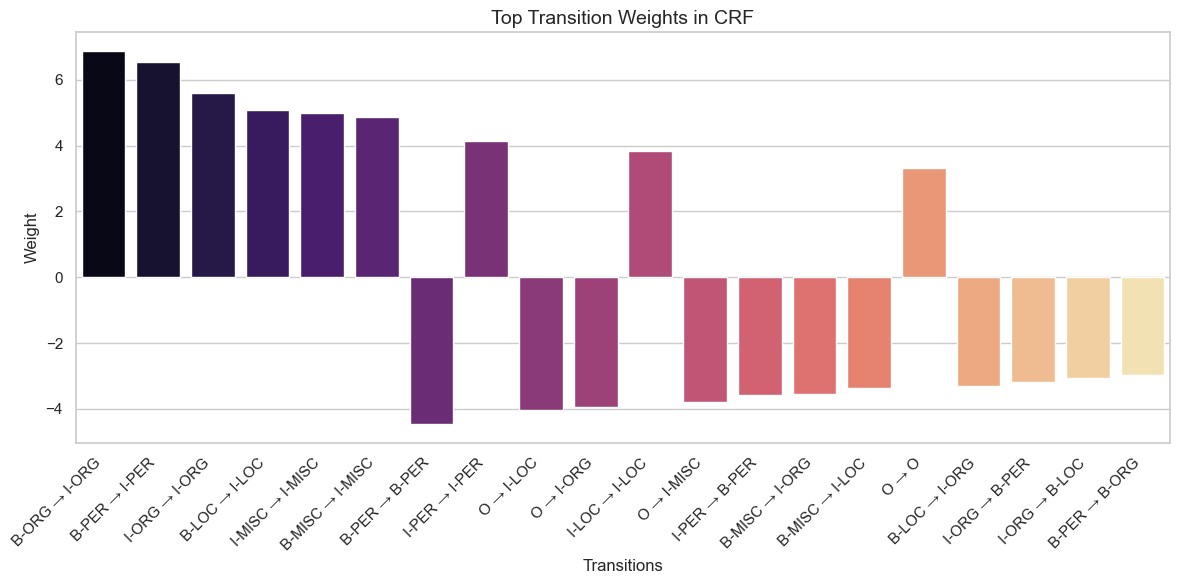

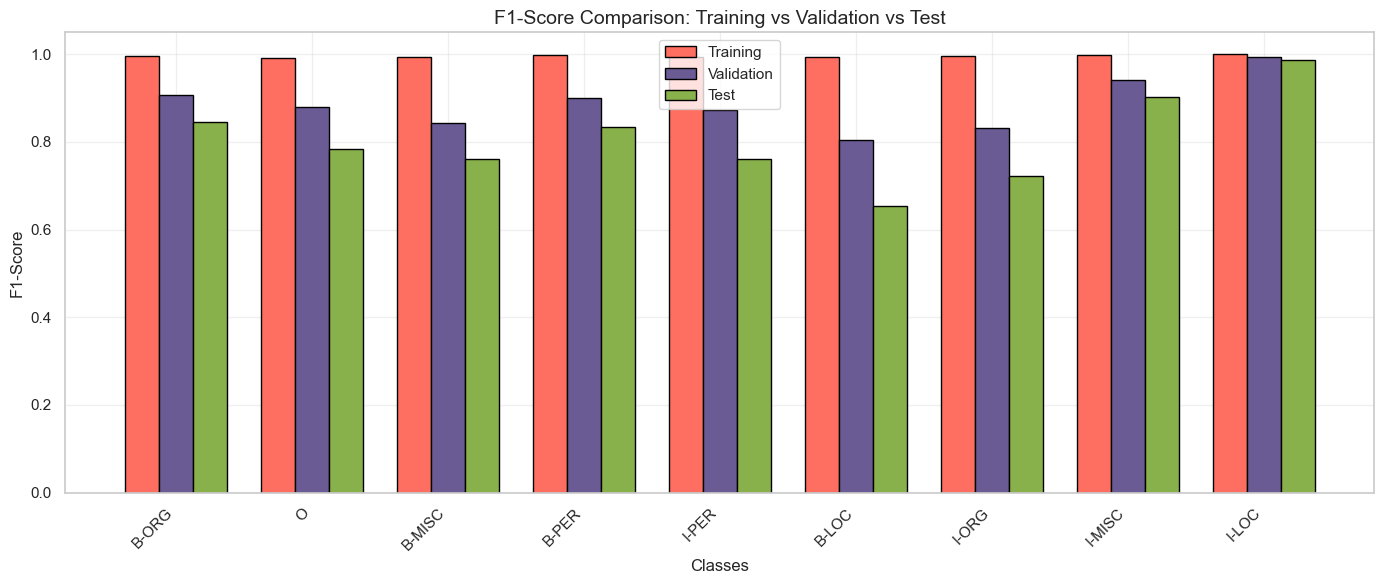

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from collections import Counter

# Set seaborn style for better visuals
sns.set(style="whitegrid", palette="muted")

# Step 1: Load CoNLL-2003 dataset
conll2003 = load_dataset("conll2003")
label_names = conll2003["train"].features["ner_tags"].feature.names

# Step 2: Prepare data for CRF
def prepare_data_for_crf(dataset):
    sentences, labels = [], []
    for example in dataset:
        words = example['tokens']
        ner_tags = [label_names[tag] for tag in example['ner_tags']]
        sentences.append(words)
        labels.append(ner_tags)
    return sentences, labels

X_train, y_train = prepare_data_for_crf(conll2003['train'])
X_val, y_val = prepare_data_for_crf(conll2003['validation'])
X_test, y_test = prepare_data_for_crf(conll2003['test'])

# Step 3: Enhanced NER Tag Distribution Plot
def plot_ner_distribution(y_data, title):
    label_counts = Counter(tag for seq in y_data for tag in seq)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=list(label_counts.keys()), 
        y=list(label_counts.values()), 
        hue=list(label_counts.keys()), 
        palette="viridis", 
        legend=False
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(title, fontsize=14, pad=10)
    plt.xlabel("NER Tags", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

plot_ner_distribution(y_train, "NER Tag Distribution in Training Set")
plot_ner_distribution(y_val, "NER Tag Distribution in Validation Set")
plot_ner_distribution(y_test, "NER Tag Distribution in Test Set")

# Step 4: Feature extraction for CRF
def word2features(sent, i):
    word = sent[i]
    features = {
        'bias': 1.0,
        'word.lower': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper': word.isupper(),
        'word.istitle': word.istitle(),
        'word.isdigit': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1]
        features.update({
            'prev_word.lower': word1.lower(),
            'prev_word.istitle': word1.istitle(),
            'prev_word.isupper': word1.isupper()
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            'next_word.lower': word1.lower(),
            'next_word.istitle': word1.istitle(),
            'next_word.isupper': word1.isupper()
        })
    else:
        features['EOS'] = True
    return features

def extract_features(sentences):
    return [[word2features(sent, i) for i in range(len(sent))] for sent in sentences]

X_train_feats = extract_features(X_train)
X_val_feats = extract_features(X_val)
X_test_feats = extract_features(X_test)

# Step 5: Train CRF Model
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_feats, y_train)

# Step 6: Evaluation with all plots
def evaluate_model(X, y_true, split_name, labels):
    y_pred = crf.predict(X)
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]
    
    print(f"{split_name} Classification Report:")
    report = classification_report(y_true_flat, y_pred_flat, target_names=labels, output_dict=True)
    print(classification_report(y_true_flat, y_pred_flat, target_names=labels))
    
    # Precision-Recall Curve (using marginal probabilities)
    plt.figure(figsize=(10, 6))
    plotted_curves = False
    for label in ['B-PER', 'I-PER', 'B-LOC', 'O']:
        try:
            label_idx = labels.index(label)
            y_true_binary = [1 if tag == label else 0 for tag in y_true_flat]
            # Flatten marginal probabilities across all sequences
            marginals = [prob[label] for seq in crf.predict_marginals(X) for prob in seq]
            y_score = marginals[:len(y_true_binary)]  # Ensure length matches
            precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')
            plotted_curves = True
        except (ValueError, KeyError):
            continue
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve - {split_name}', fontsize=14)
    if plotted_curves:
        plt.legend(loc='best')
    else:
        plt.text(0.5, 0.5, 'No valid curves plotted', ha='center', va='center', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Confusion Matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        xticklabels=labels, 
        yticklabels=labels, 
        cmap='RdYlBu',
        cbar_kws={'label': 'Count'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.title(f"Confusion Matrix - {split_name}", fontsize=14, pad=10)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return y_pred, report

# Evaluate on all sets
y_train_pred, train_report = evaluate_model(X_train_feats, y_train, "Training Set", crf.classes_)
y_val_pred, val_report = evaluate_model(X_val_feats, y_val, "Validation Set", crf.classes_)
y_test_pred, test_report = evaluate_model(X_test_feats, y_test, "Test Set", crf.classes_)

# Step 7: Transition Weights Visualization
def plot_transition_weights(crf, top_n=20):
    transitions = crf.transition_features_
    sorted_trans = sorted(transitions.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
    from_labels, to_labels = zip(*[t[0] for t in sorted_trans])
    weights = [t[1] for t in sorted_trans]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=[f"{f} → {t}" for f, t in zip(from_labels, to_labels)], 
        y=weights, 
        hue=[f"{f} → {t}" for f, t in zip(from_labels, to_labels)], 
        palette="magma", 
        legend=False
    )
    plt.xticks(rotation=45, ha='right')
    plt.title("Top Transition Weights in CRF", fontsize=14)
    plt.xlabel("Transitions", fontsize=12)
    plt.ylabel("Weight", fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

plot_transition_weights(crf)

# Step 8: F1-Score Comparison Plot
def plot_f1_comparison(train_report, val_report, test_report, title):
    classes = [c for c in val_report.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]
    train_f1 = [train_report[c]['f1-score'] for c in classes]
    val_f1 = [val_report[c]['f1-score'] for c in classes]
    test_f1 = [test_report[c]['f1-score'] for c in classes]
    
    x = np.arange(len(classes))
    width = 0.25
    plt.figure(figsize=(14, 6))
    plt.bar(x - width, train_f1, width, label='Training', color='#FF6F61', edgecolor='black')
    plt.bar(x, val_f1, width, label='Validation', color='#6B5B95', edgecolor='black')
    plt.bar(x + width, test_f1, width, label='Test', color='#88B04B', edgecolor='black')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()

plot_f1_comparison(train_report, val_report, test_report, "F1-Score Comparison: Training vs Validation vs Test")

Random Forest

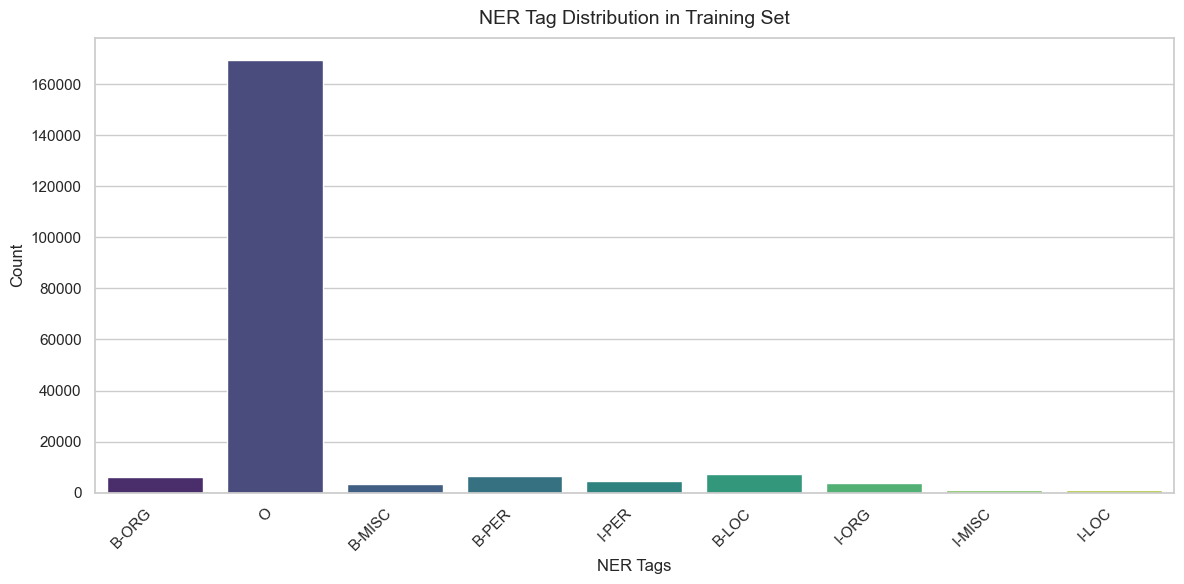

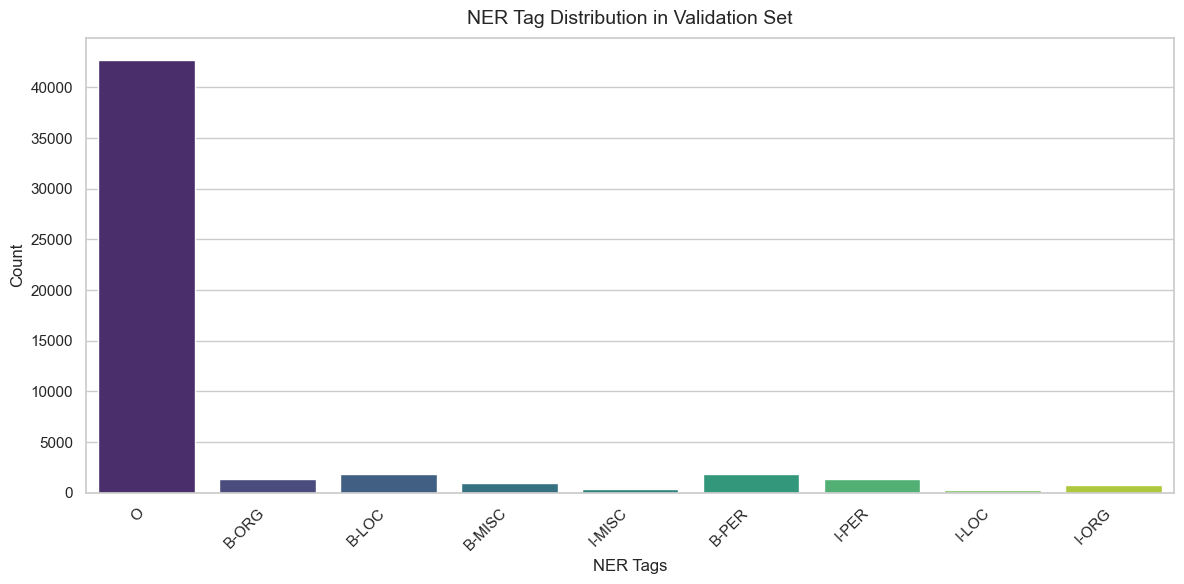

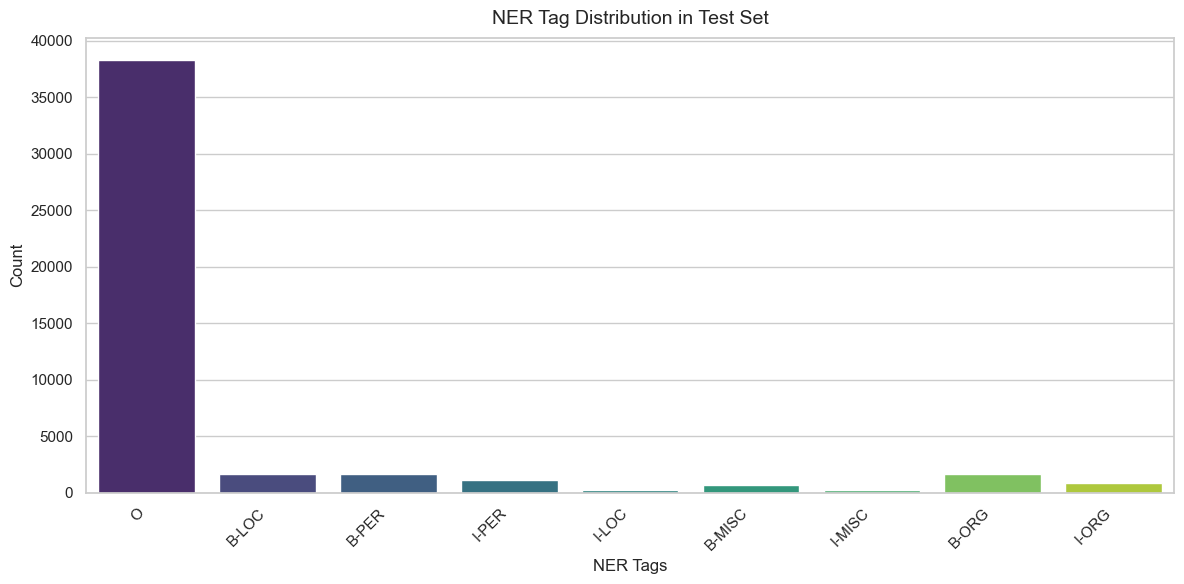

Training Set Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.47      0.72      0.56      7140
      B-MISC       0.18      0.75      0.29      3438
       B-ORG       0.31      0.62      0.42      6321
       B-PER       0.33      0.59      0.43      6600
       I-LOC       0.66      0.80      0.72      1157
      I-MISC       0.27      0.78      0.40      1155
       I-ORG       0.66      0.56      0.61      3704
       I-PER       0.09      0.93      0.17      4528
           O       0.99      0.59      0.74    169578

    accuracy                           0.61    203621
   macro avg       0.44      0.70      0.48    203621
weighted avg       0.89      0.61      0.69    203621



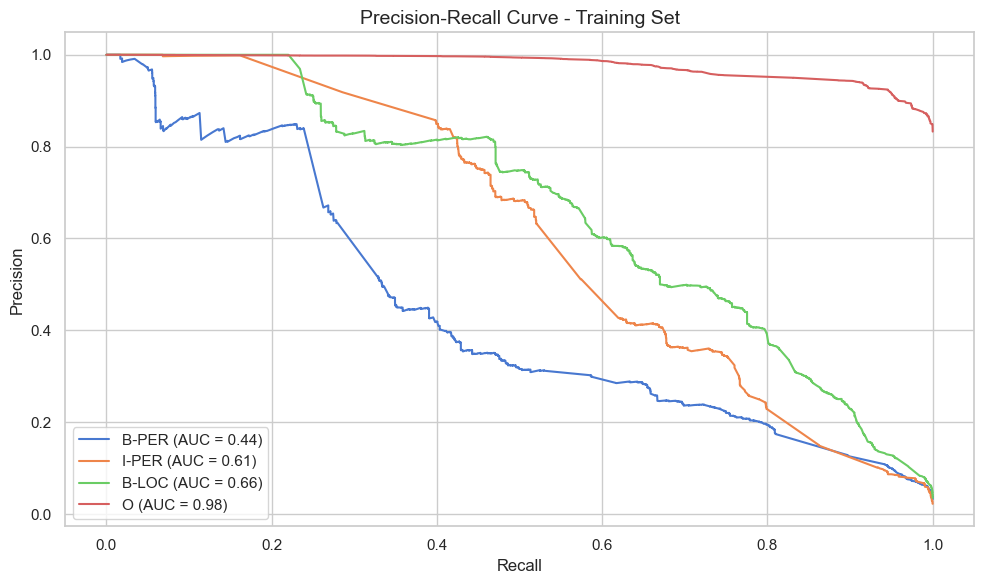

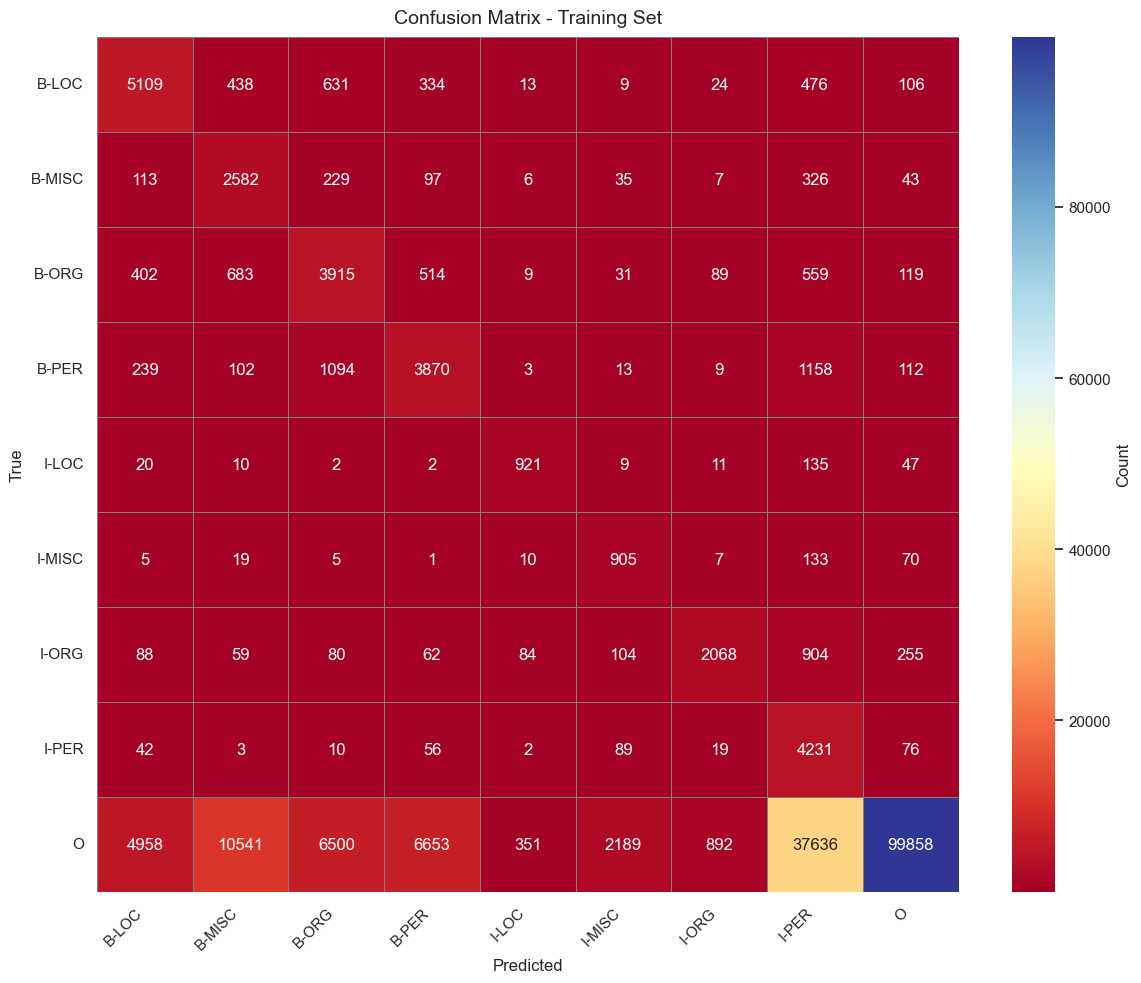

Validation Set Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.41      0.62      0.50      1837
      B-MISC       0.17      0.69      0.27       922
       B-ORG       0.23      0.50      0.31      1341
       B-PER       0.35      0.58      0.44      1842
       I-LOC       0.52      0.69      0.59       257
      I-MISC       0.21      0.66      0.32       346
       I-ORG       0.48      0.40      0.43       751
       I-PER       0.10      0.89      0.18      1307
           O       0.99      0.58      0.73     42759

    accuracy                           0.59     51362
   macro avg       0.38      0.62      0.42     51362
weighted avg       0.87      0.59      0.67     51362



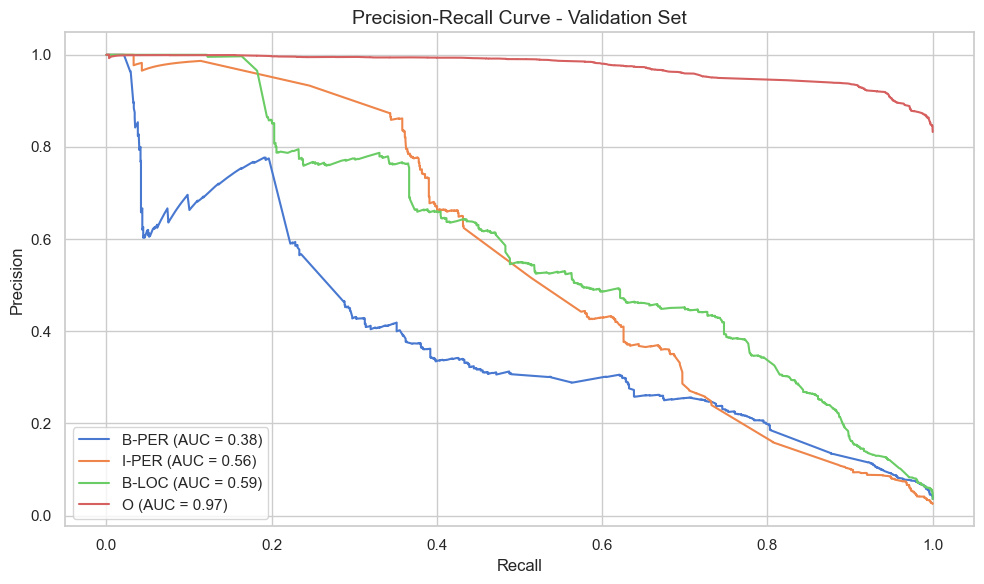

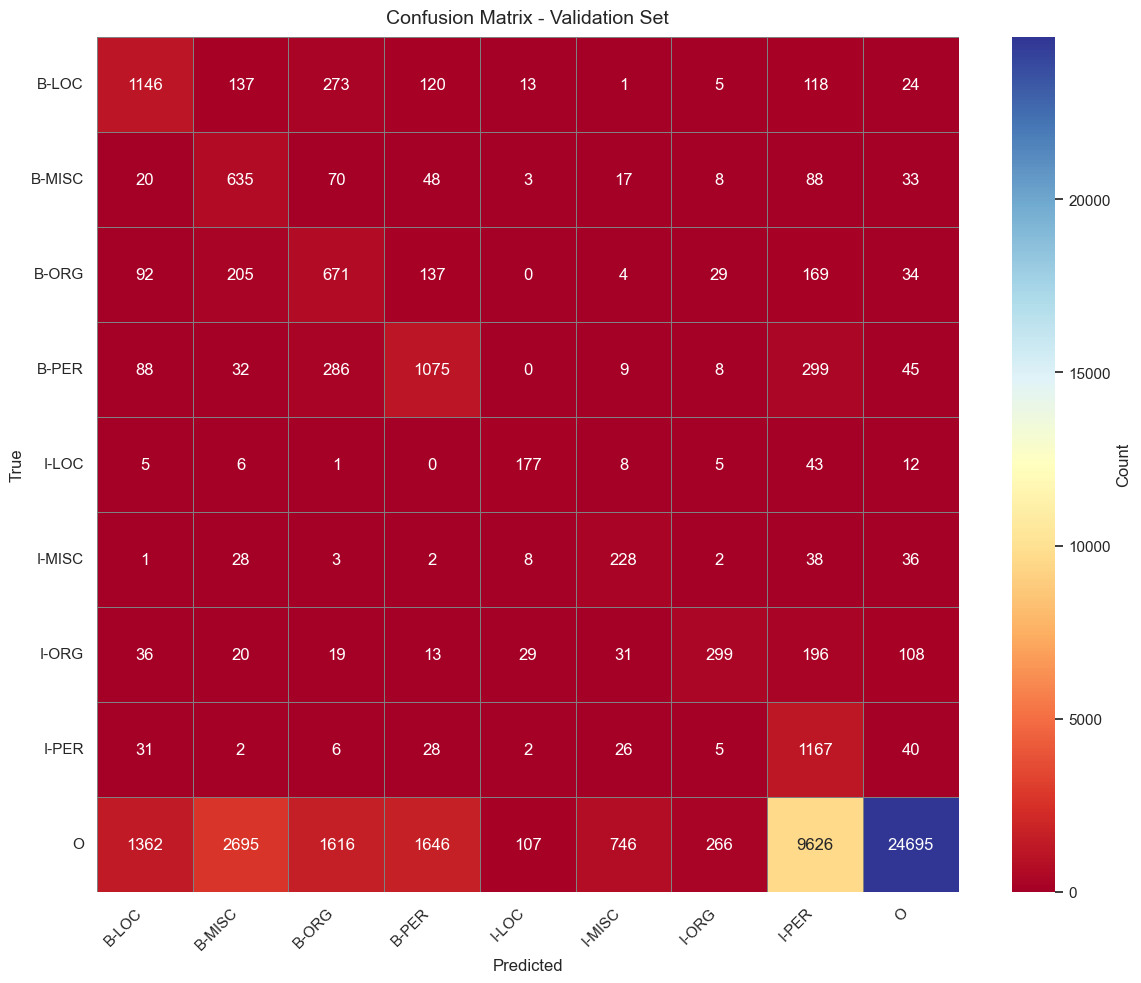

Test Set Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.39      0.56      0.46      1668
      B-MISC       0.15      0.67      0.25       702
       B-ORG       0.29      0.58      0.39      1661
       B-PER       0.34      0.53      0.42      1617
       I-LOC       0.48      0.63      0.55       257
      I-MISC       0.13      0.66      0.22       216
       I-ORG       0.49      0.38      0.43       835
       I-PER       0.10      0.89      0.18      1156
           O       0.99      0.59      0.74     38323

    accuracy                           0.59     46435
   macro avg       0.37      0.61      0.40     46435
weighted avg       0.87      0.59      0.68     46435



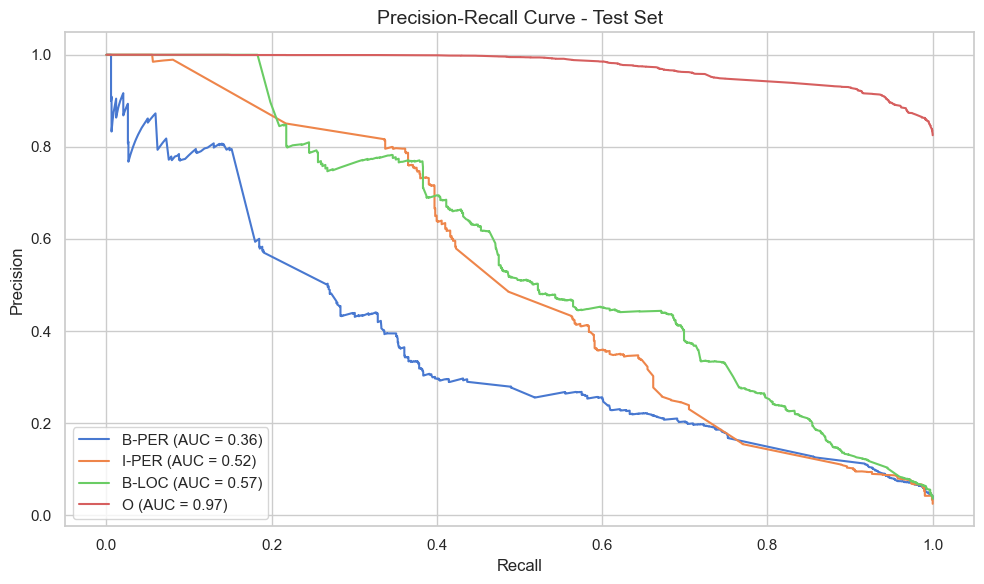

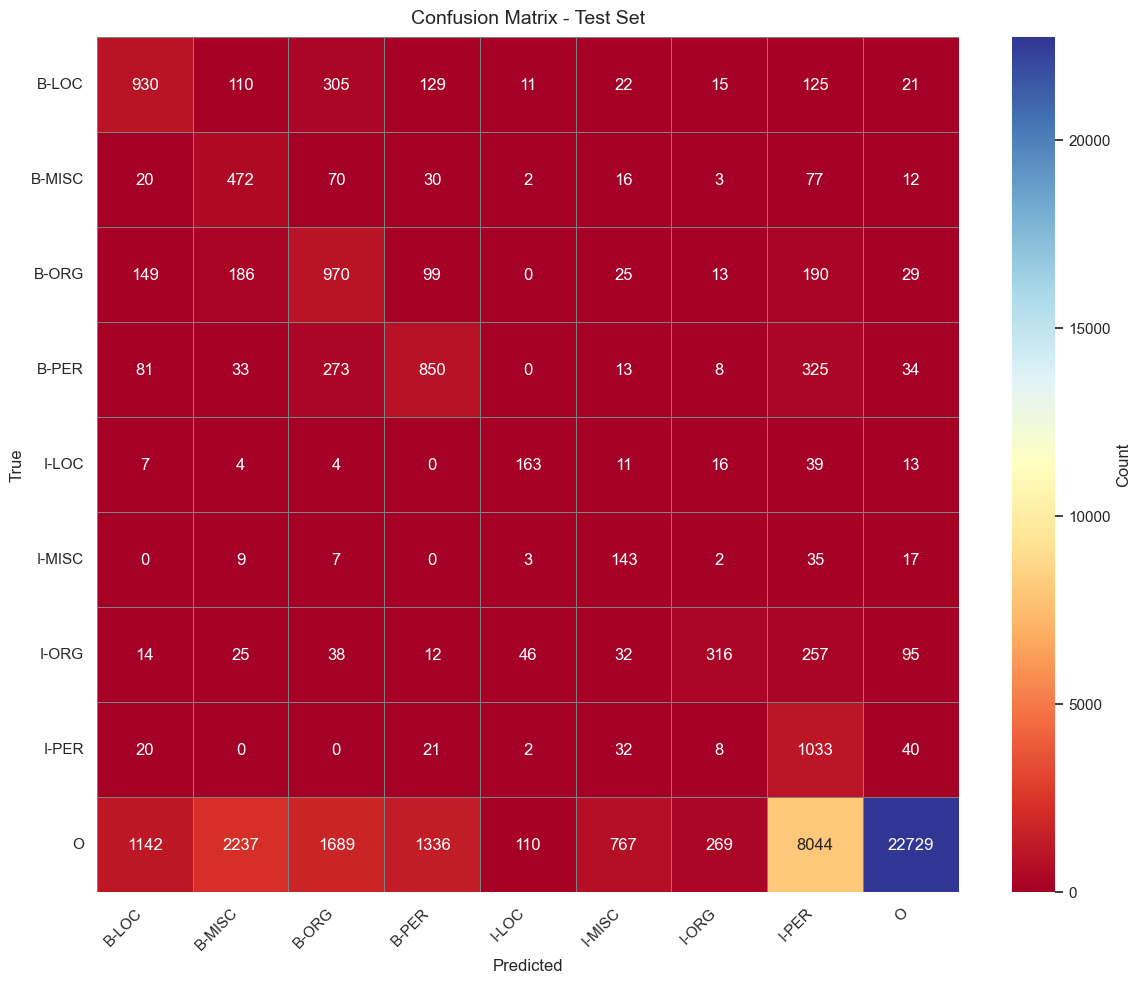

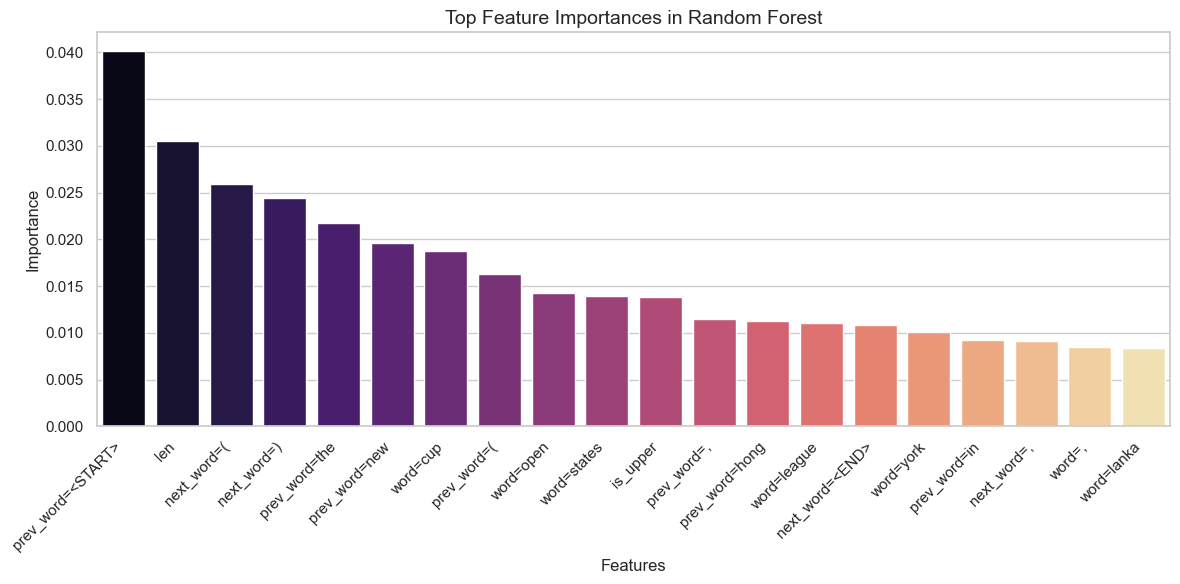

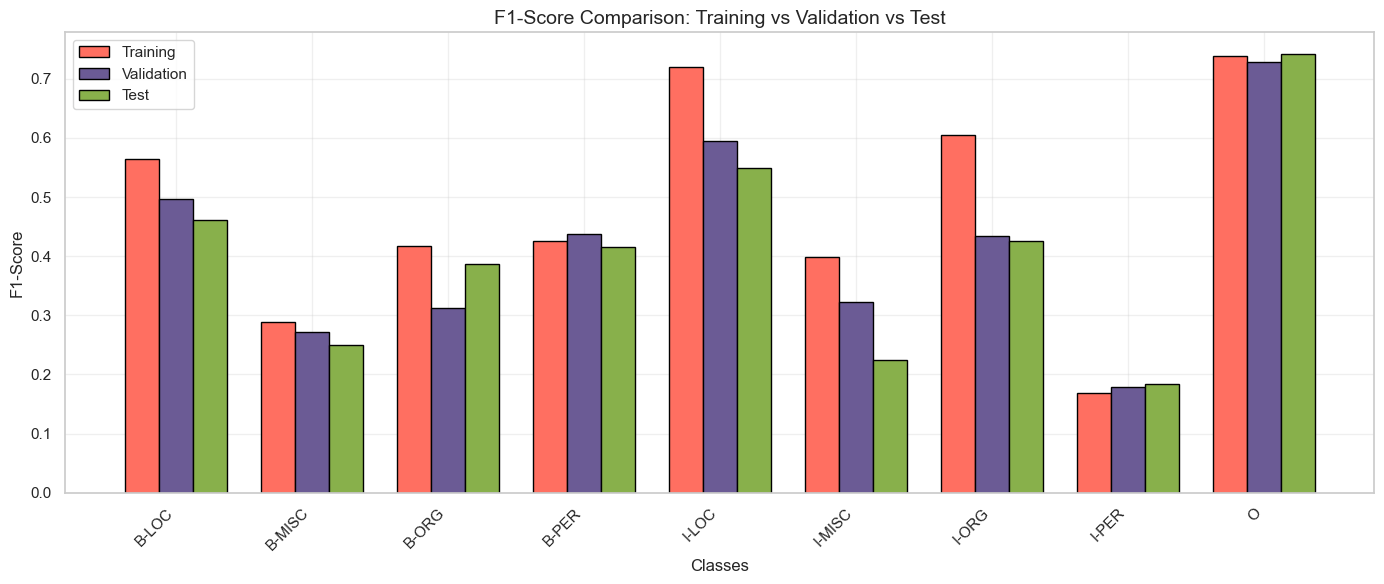

46746

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse
import gc
from collections import Counter

# Set seaborn style for better visuals
sns.set(style="whitegrid", palette="muted")

# Enable garbage collection
gc.enable()

# Step 1: Load CoNLL-2003 dataset with streaming
conll2003 = load_dataset("conll2003", streaming=True)
label_names = load_dataset("conll2003")["train"].features["ner_tags"].feature.names

# Step 2: Optimized data preparation with generator
def prepare_data_generator(dataset_split):
    for example in dataset_split:
        words = example['tokens']
        ner_tags = [label_names[tag] for tag in example['ner_tags']]
        yield {'words': words, 'tags': ner_tags}

# Enhanced feature extraction
def extract_features(words):
    features = []
    for i, w in enumerate(words):
        feat = {
            'word': w.lower(),
            'len': len(w),
            'is_upper': w.isupper(),
            'is_digit': w.isdigit(),
            'prev_word': words[i-1].lower() if i > 0 else '<START>',
            'next_word': words[i+1].lower() if i < len(words)-1 else '<END>'
        }
        features.append(feat)
    return features

# Process data in chunks
def process_data_in_chunks(split_name, chunk_size=1000):
    X_feats, y = [], []
    generator = prepare_data_generator(conll2003[split_name])
    chunk_X, chunk_y = [], []
    count = 0
    
    for data in generator:
        chunk_X.append(extract_features(data['words']))
        chunk_y.append(data['tags'])
        count += 1
        
        if count >= chunk_size:
            X_feats.extend(chunk_X)
            y.extend(chunk_y)
            chunk_X, chunk_y = [], []
            count = 0
    
    if chunk_X:
        X_feats.extend(chunk_X)
        y.extend(chunk_y)
    
    return X_feats, y

# Prepare datasets
X_train_feats, y_train = process_data_in_chunks('train')
X_val_feats, y_val = process_data_in_chunks('validation')
X_test_feats, y_test = process_data_in_chunks('test')

# Step 3: Enhanced NER distribution plot
def plot_ner_distribution(y_data, title):
    label_counts = Counter(tag for seq in y_data for tag in seq)
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=list(label_counts.keys()), 
        y=list(label_counts.values()), 
        hue=list(label_counts.keys()), 
        palette="viridis", 
        legend=False
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(title, fontsize=14, pad=10)
    plt.xlabel("NER Tags", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

plot_ner_distribution(y_train, "NER Tag Distribution in Training Set")
plot_ner_distribution(y_val, "NER Tag Distribution in Validation Set")
plot_ner_distribution(y_test, "NER Tag Distribution in Test Set")

# Step 4: Vectorization
vectorizer = DictVectorizer(sparse=True)
X_train_flat = [item for sublist in X_train_feats for item in sublist]
X_train_vec = vectorizer.fit_transform(X_train_flat)
del X_train_flat
gc.collect()

X_val_vec = vectorizer.transform([item for sublist in X_val_feats for item in sublist])
X_test_vec = vectorizer.transform([item for sublist in X_test_feats for item in sublist])

# Flatten and encode labels
y_train_flat = [item for sublist in y_train for item in sublist]
y_val_flat = [item for sublist in y_val for item in sublist]
y_test_flat = [item for sublist in y_test for item in sublist]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_flat)
y_val_encoded = label_encoder.transform(y_val_flat)
y_test_encoded = label_encoder.transform(y_test_flat)

del y_train_flat, y_val_flat, y_test_flat
gc.collect()

# Step 5: Train Random Forest with class weighting
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=30,
    min_samples_split=5,
    class_weight='balanced'
)
rf.fit(X_train_vec, y_train_encoded)

# Step 6-9: Evaluation with confusion matrix for all sets
def evaluate_model(X, y_true, split_name, labels):
    y_pred = rf.predict(X)
    print(f"{split_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=labels,
        zero_division=0,
        output_dict=True
    )
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))
    
    # Precision-Recall Curve for key classes
    plt.figure(figsize=(10, 6))
    for label in ['B-PER', 'I-PER', 'B-LOC', 'O']:
        label_idx = label_encoder.transform([label])[0]
        y_true_binary = (y_true == label_idx).astype(int)
        y_score = rf.predict_proba(X)[:, label_idx]
        precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve - {split_name}', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        xticklabels=labels, 
        yticklabels=labels, 
        cmap='RdYlBu',
        cbar_kws={'label': 'Count'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.title(f"Confusion Matrix - {split_name}", fontsize=14, pad=10)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return y_pred, report

# Evaluate on all sets
y_train_pred, train_report = evaluate_model(X_train_vec, y_train_encoded, "Training Set", label_encoder.classes_)
y_val_pred, val_report = evaluate_model(X_val_vec, y_val_encoded, "Validation Set", label_encoder.classes_)
y_test_pred, test_report = evaluate_model(X_test_vec, y_test_encoded, "Test Set", label_encoder.classes_)

# Step 10: Feature Importance Plot
def plot_feature_importance(rf, vectorizer, top_n=20):
    importances = rf.feature_importances_
    feature_names = vectorizer.feature_names_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=[feature_names[i] for i in indices], 
        y=importances[indices], 
        hue=[feature_names[i] for i in indices], 
        palette="magma", 
        legend=False
    )
    plt.xticks(rotation=45, ha='right')
    plt.title("Top Feature Importances in Random Forest", fontsize=14)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Importance", fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

plot_feature_importance(rf, vectorizer)

# Step 11: F1-Score Comparison Plot
def plot_f1_comparison(train_report, val_report, test_report, title):
    classes = [c for c in val_report.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]
    train_f1 = [train_report[c]['f1-score'] for c in classes]
    val_f1 = [val_report[c]['f1-score'] for c in classes]
    test_f1 = [test_report[c]['f1-score'] for c in classes]
    
    x = np.arange(len(classes))
    width = 0.25
    plt.figure(figsize=(14, 6))
    plt.bar(x - width, train_f1, width, label='Training', color='#FF6F61', edgecolor='black')
    plt.bar(x, val_f1, width, label='Validation', color='#6B5B95', edgecolor='black')
    plt.bar(x + width, test_f1, width, label='Test', color='#88B04B', edgecolor='black')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()

plot_f1_comparison(train_report, val_report, test_report, "F1-Score Comparison: Training vs Validation vs Test")

# Clean up
del X_train_vec, X_val_vec, X_test_vec
gc.collect()